In [10]:
import rvnewop as rv
from glob import glob
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
from itertools import accumulate

Processing ./embench_hst/matmult-int.hst...
instruction #0


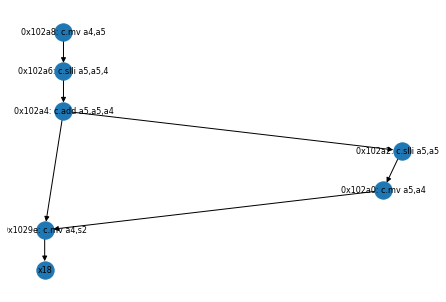

instruction #1


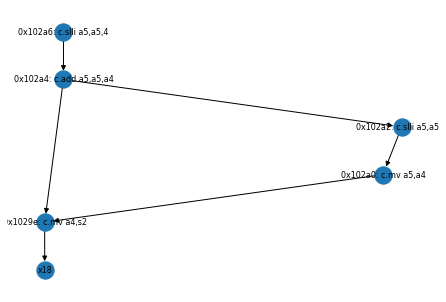

instruction #2


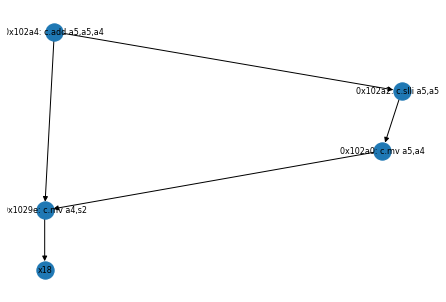

instruction #3


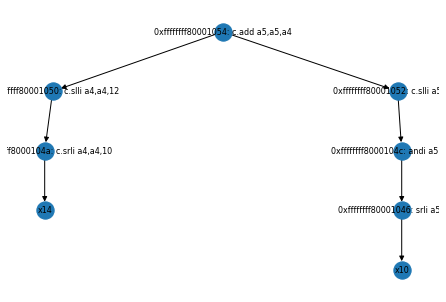

instruction #4


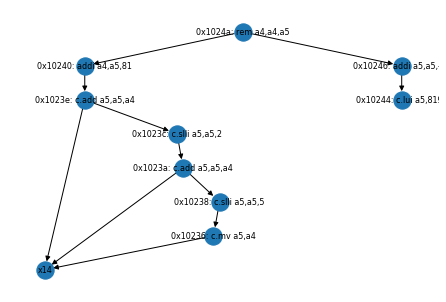

instruction #5


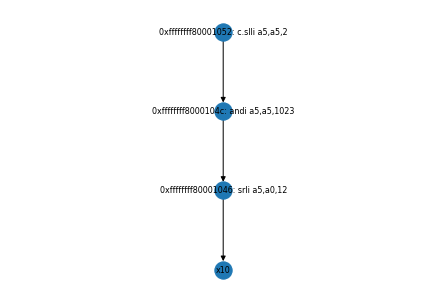

instruction #6


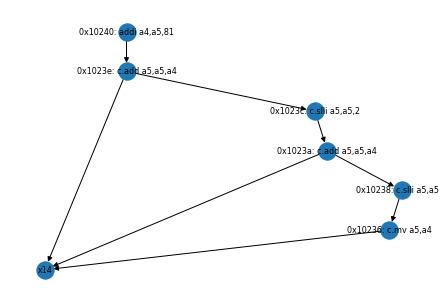

instruction #7


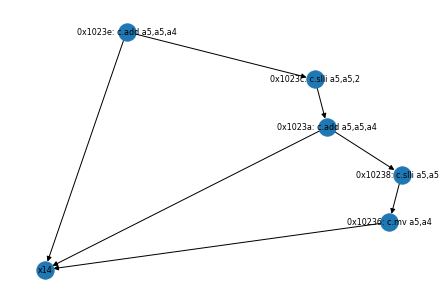

instruction #8


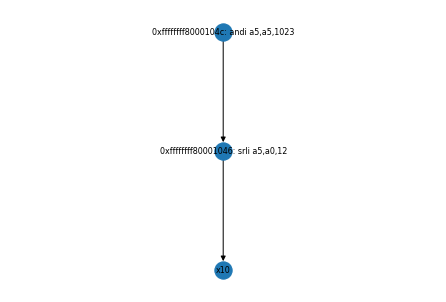

instruction #9


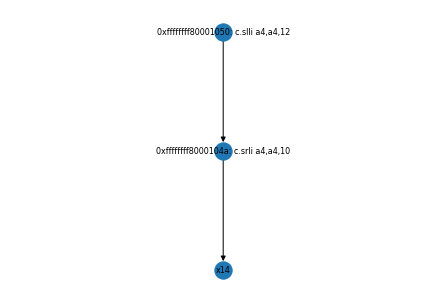

Saved 18339450 cycles out of 19196666 (95.53%) with 126 new instructions
max depth: 6
max mult depth: 7


In [11]:
%matplotlib inline
FILENAME = "./embench_hst/matmult-int.hst"
print("Processing {}...".format(FILENAME))

prog = rv.Histogram.parse(FILENAME, isa="32ICM")
prog.findBasicBlocks()

prog.addLivenessValuesToGraph()

# total cycles = sum of all the frequencies
total_cycles = sum(
    [inst.freq for bb in prog.basicBlocks for inst in bb.bbInstructions()]
)

new_instructions = []

for i, b in enumerate((prog.getSubBlocks())):
    graph = b.constructDAG()

    # temp will store every permutation of candidate subgraphs
    temp = []
    for n in rv.analysis.findCandidateSubgraphs(prog, graph):
        subtree = rv.analysis.createSubtreeFromNode(graph, n)
        root = n

        temp.append(rv.Subgraph(subtree, root))

    # add candidate subgraph with highest score to new instructions list
    current_nodes = set()
    temp = sorted(temp, key=lambda sg: sg.score, reverse=True)
    while temp:
        if any([(n in current_nodes) for n in temp[0].graph.nodes]):
            temp.pop(0)
        else:
            new_instructions.append(temp.pop(0))

new_instructions = sorted(new_instructions, key=lambda sg: sg.score, reverse=True)

inst_dict = {}
for subgraph in new_instructions:
    key = rv.analysis.graphToParenString(subgraph.graph)

    if key in inst_dict:
        inst_dict[key].score += subgraph.score
    else:
        inst_dict[key] = subgraph

new_instructions = [inst_dict[key] for key in inst_dict]

max_depth = 0
max_mult_depth = 0
for sg in new_instructions:
    if sg.containsMultiplyInstruction():
        max_mult_depth = max(max_mult_depth, sg.depth)
    else:
        max_depth = max(max_depth, sg.depth)

saved_cycles = sum([sg.score for sg in new_instructions])
percent_cycles = float(saved_cycles) / total_cycles * 100
#plt.clf()
#plt.plot([x for x in range(len(new_instructions))],list(map(lambda x:x/total_cycles, accumulate([sg.score for sg in new_instructions]))))
#plt.show()

i = 0
for sg in new_instructions[:10]:
    print("instruction #{}".format(i))
    plt.clf()
    pos = graphviz_layout(sg.graph, prog="dot")
    nx.draw(sg.graph, pos, with_labels=True, font_size=8)
    plt.show()
    i+=1

print(
    """Saved {} cycles out of {} ({:.4}%) with {} new instructions""".format(
        saved_cycles, total_cycles, percent_cycles, len(new_instructions)
    )
)
print("max depth: {}\nmax mult depth: {}".format(max_depth, max_mult_depth))
